<a href="https://colab.research.google.com/github/rizaho/ml_for_financial_analysis/blob/main/201_3_ARIMA_SARIMA_SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from google.colab import drive
import seaborn as sns
%matplotlib inline
from copy import copy
from scipy import stats
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import math
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # auto correlation, partial auto-correlation
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing


# runtime settings
import sys
#np.set_printoptions(threshold=sys.maxsize)

In [5]:
# read data from google drive
drive.mount('/content/drive')
DATA_ROOT_PATH = "Python-Time-Series-Forecasting"
# /content/drive/MyDrive/Colab Notebooks/Python-Time-Series-Forecasting/ARIMA, SARIMA and SARIMAX
DATA_SUB_INTRO = "ARIMA, SARIMA and SARIMAX"
DRIVE_DATASET_PATH = "/content/drive/My Drive/Colab Notebooks/" + DATA_ROOT_PATH + "/" + DATA_SUB_INTRO + "/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# read data

In [8]:
df = pd.read_csv(DRIVE_DATASET_PATH + "daily_revenue.csv",
                 index_col = "date",
                 parse_dates=True,
                 dayfirst = True)
df.head()

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,"6,270,839",34.27%,1.09%
2018-01-02,"8,922,076",30.87%,1.08%
2018-01-03,"8,446,101",28.11%,1.01%
2018-01-04,"7,785,798",27.32%,0.96%
2018-01-05,"6,375,303",25.70%,0.90%


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   revenue        1795 non-null   object
 1   discount_rate  1795 non-null   object
 2   coupon_rate    1795 non-null   object
dtypes: object(3)
memory usage: 56.1+ KB


# Data modification

In [11]:
# revenue, discount_rate, and coupon_rate are all objects. So convert them into float.
# Convert revenue into float
df['revenue'] = df['revenue'].str.replace(',','').astype(float)
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        1795 non-null   float64
 1   discount_rate  1795 non-null   object 
 2   coupon_rate    1795 non-null   object 
dtypes: float64(1), object(2)
memory usage: 56.1+ KB


In [12]:
# update frequency
df = df.asfreq("D") # frequency is [D]aily.
df.index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-11-21', '2022-11-22', '2022-11-23', '2022-11-24',
               '2022-11-25', '2022-11-26', '2022-11-27', '2022-11-28',
               '2022-11-29', '2022-11-30'],
              dtype='datetime64[ns]', name='date', length=1795, freq='D')

In [17]:
# change column name revenue to y
df.rename(columns={'revenue': 'y'}, inplace=True)
df

,y,discount_rate,coupon_rate
date,,,
2018-01-01,6270839.0,34.27%,1.09%
2018-01-02,8922076.0,30.87%,1.08%
2018-01-03,8446101.0,28.11%,1.01%
2018-01-04,7785798.0,27.32%,0.96%
2018-01-05,6375303.0,25.70%,0.90%
...,...,...,...
2022-11-26,26934947.0,30.41%,0.38%
2022-11-27,31890868.0,29.75%,0.35%
2022-11-28,32100918.0,25.27%,8.93%


# Explotary Data Analysis

## Plot - Daily Revenues

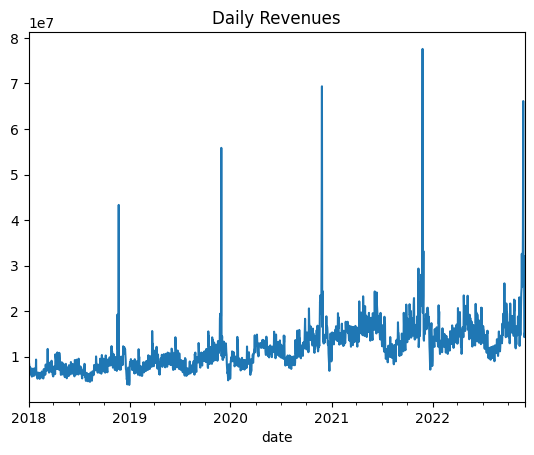

In [18]:
df["y"].plot(title = "Daily Revenues")
plt.show()

## Plot - Montly Revenues

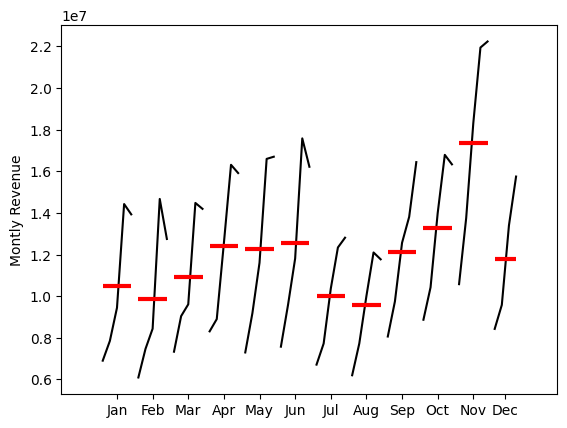

In [21]:
month_plot(df["y"].resample("ME").mean(),
           ylabel="Montly Revenue")
plt.show()

## Plot - Quarterly Revenues

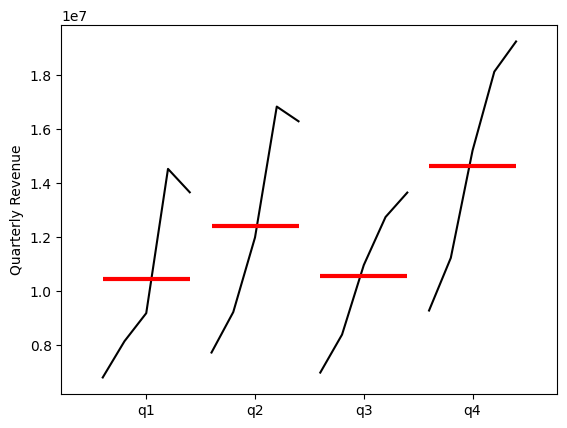

In [22]:
# Plot quarterly revenues
quarter_plot(df["y"].resample("QE").mean(),
             ylabel="Quarterly Revenue")
plt.show()



# Seasonal Decomposition

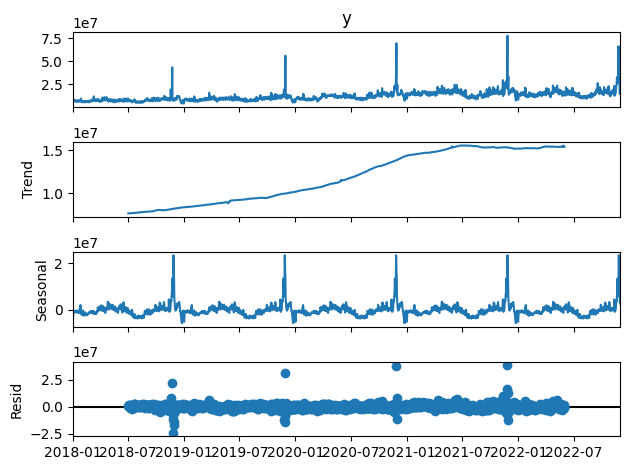

In [23]:
# Plot seasonal decomposition
seasonal_decomposition = seasonal_decompose(
    df["y"],
    model="additive",
    period = 365)
fig = seasonal_decomposition.plot()
plt.show()

# Auto Correlation

## Auto Correlation (ACF)

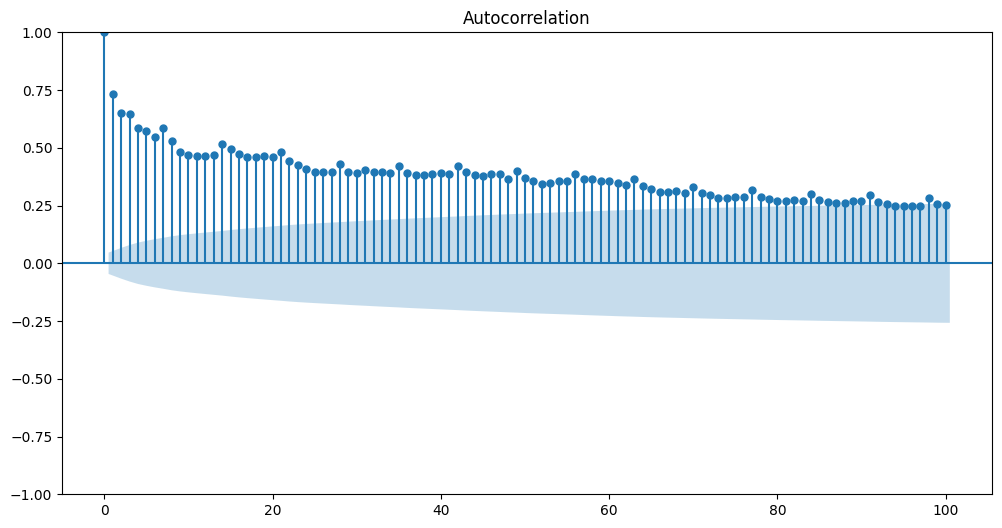

In [24]:
# Plot auto correlation (ACF)
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(df["y"], lags=100, ax = ax)
plt.show()

## Partial Auto Correlation (PACF)

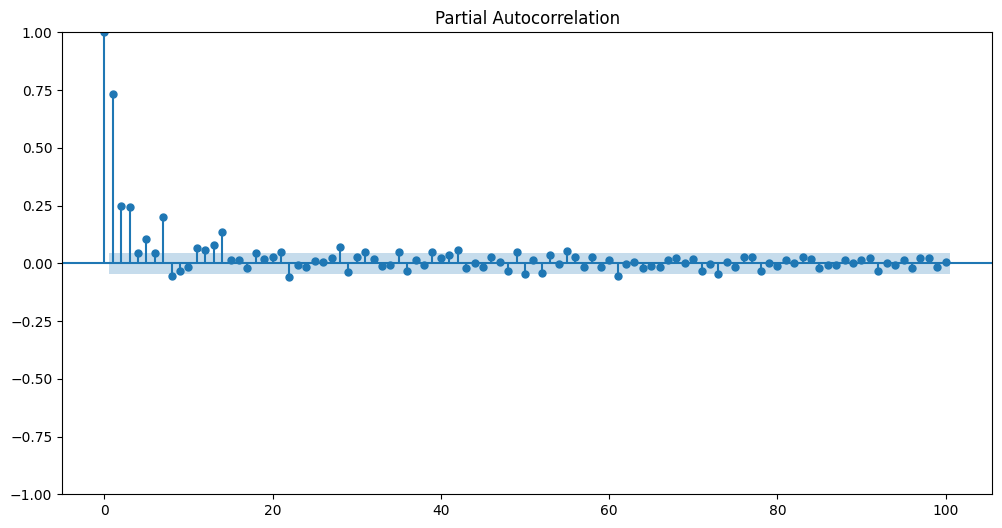

In [25]:
# Plot partial auto correlation (PACF)
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(df["y"], lags=100, ax = ax)
plt.show()